# Market Risk Evaluation Using Beta Coefficient 

In [23]:
import yfinance as yf
import datetime as dt
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm
import matplotlib.pyplot as plt

In the below code block, the code fetches a table from a Wikipedia page, extracts the ticker symbols of the S&P 500 companies from the table, and stores them in the tickers variable for subsequent processing.

In [24]:
# Fetching of tickers list from Wikipedia
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = table[0]
tickers = df.Symbol

The below code block fetches the historical close values of the S&P 500 index from Yahoo Finance. It determines the date range for the data, which is one year prior to the current date. The code then downloads the historical data for the S&P 500 index, specifically the "Close" values, and stores them in a variable called "SP500." It renames the "SP500" column to make it easily identifiable. Additionally, it calculates the logarithmic returns of the S&P 500 index based on the closing prices and stores them in a variable called "SP500_log_return."

In [77]:
# Fetching of S&P 500 close values from yahoo finance
end = dt.datetime.now() 
start = end - relativedelta(years=1)
data = yf.download('^GSPC',start=start,end=end)
SP500 = data['Close']
SP500.rename('SP500', inplace=True)
SP500_log_return = np.log(SP500/SP500.shift())


[*********************100%***********************]  1 of 1 completed


We initialize two empty lists, dfs and betas, to store the extracted data and calculated betas, respectively.

For each ticker in the list of tickers, we proceed with the following steps:

1- We use the yf.download() function from Yahoo Finance to fetch the historical data for the specified ticker, within the given start and end dates. By setting progress to False, we disable the progress indicator to avoid displaying unnecessary output.

2- We assign the 'Close' column of the downloaded data to a variable called StockPrice, representing the close prices of the specific stock.

3- We check if the downloaded data has a length greater than zero (i.e., it is not empty). If it is not empty, we continue with further processing. Otherwise, we skip to the next iteration.

4- We concatenate the StockPrice series with the SP500 series, representing the S&P 500 close prices, along the axis of 1 (column-wise). This creates a merged DataFrame that aligns the two series based on their index.

5- We calculate the logarithmic return of the merged DataFrame by taking the natural logarithm of the ratio between each value and its preceding value. We then drop any rows with missing values (NaN) resulting from the logarithmic transformation.

6- We add a constant column to the logarithmic return DataFrame using the add_constant() function from the statsmodels library. This is necessary for the linear regression analysis.

7- We perform linear regression using the sm.OLS() function from statsmodels. We specify the dependent variable as the logarithmic return of the specific stock (indexed by ticker) and the independent variable as the logarithmic return of the S&P 500.

8- We retrieve the beta coefficient from the regression results using model.fit().params[1] and append it to the betas list.

9- We append the StockPrice series to the dfs list.

If the downloaded data for a particular ticker is empty, we continue to the next iteration without performing any calculations.

In [82]:
# Extracting close prices of stocks using yahoo finance and calculate betas using linear regression
dfs = []
betas = []
for ticker in tickers:
    data = yf.download(ticker, start=start, end=end,progress=False)
    data[ticker] = data['Close']
    StockPrice = data[ticker]
    if len(data) !=0:
        merged = pd.concat([StockPrice,SP500], axis=1)
        log_return = np.log(merged/merged.shift()).dropna()
        Y = sm.add_constant(log_return['SP500'])
        model = sm.OLS(log_return[ticker], Y)
        betas.append(model.fit().params[1])
        dfs.append(StockPrice)
    else:
        continue


1 Failed download:
- BRK.B: No timezone found, symbol may be delisted

1 Failed download:
- BF.B: No data found for this date range, symbol may be delisted


The below code block saves the calculated betas and close prices into separate data structures and exports them to an Excel file. The betas are stored in a DataFrame called "Betas" with the corresponding stock tickers, and the close prices are stored in a transposed DataFrame called "ClosePrices". These data structures are then written to an Excel file named "Market Data.xlsx" with two sheets: "Sheet1" for close prices and "Sheet2" for beta coefficients.

In [83]:
# Saving Betas and close prices
betas = pd.Series(betas)
betas.rename('Beta Coefficient',inplace=True)    
Betas = pd.concat([tickers,betas],axis=1)
ClosePrices = pd.DataFrame(dfs).T  
# Exporting saved data into Excel file 
writer = pd.ExcelWriter('Market Data.xlsx')
ClosePrices.to_excel(writer, sheet_name='Sheet1')
Betas.to_excel(writer, sheet_name='Sheet2')
writer.save()

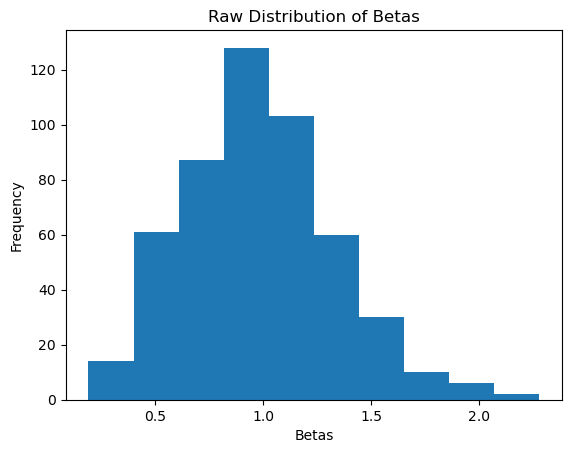

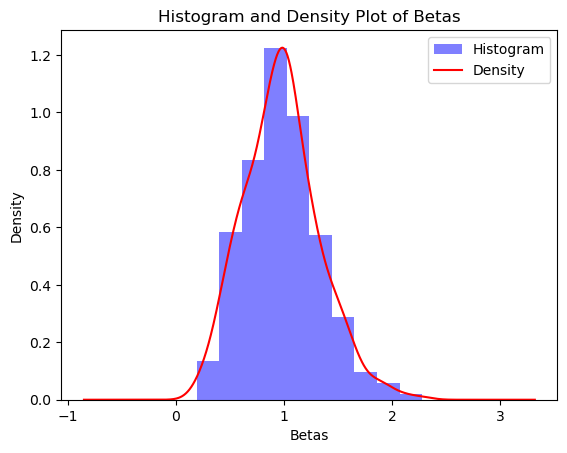

In [84]:
#Visualisation 
fig, ax1 = plt.subplots()
ax1.hist(betas)
ax1.set_title('Raw Distribution of Betas')
ax1.set_xlabel('Betas')
ax1.set_ylabel('Frequency')
plt.show()

fig, ax2 = plt.subplots()
ax2.hist(betas, density=True, alpha=0.5, color='blue', label='Histogram')
betas.plot.kde(ax=ax2, color='red', label='Density')
ax2.set_title('Histogram and Density Plot of Betas')
ax2.set_xlabel('Betas')
ax2.set_ylabel('Density')
ax2.legend()
plt.show()